# Stacking

This test taks based on data from Kaggle competion [Titanic on Kaggle](https://www.kaggle.com/c/titanic/overview)

All issues with data quality, Feature Engineering and Exploritory data analysis were taken from one of the most popular solutions: [Solution on Kaggle](https://www.kaggle.com/code/arthurtok/introduction-to-ensembling-stacking-in-python/notebook):

In [30]:
from datetime import datetime, date
import pandas as pd
import re
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('default')

import warnings
warnings.filterwarnings('ignore')

In [31]:
# Load in the train and test datasets
data_initial = pd.read_csv('./data/train.csv') # data for training and testing the model (with answers)
test_final = pd.read_csv('./data/test.csv') # data for predictions for competition (no answers)

In [32]:
test_final_passenger_id = test_final[['PassengerId']]
test_final_passenger_id.head(2)

,PassengerId
0,892
1,893


In [33]:
data_initial.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [34]:
test_final.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


In [35]:
full_data = [data_initial, test_final]

# Gives the length of the name
data_initial['Name_length'] = data_initial['Name'].apply(len)
test_final['Name_length'] = test_final['Name'].apply(len)
# Feature that tells whether a passenger had a cabin on the Titanic
data_initial['Has_Cabin'] = data_initial["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test_final['Has_Cabin'] = test_final["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(data_initial['Fare'].median())
data_initial['CategoricalFare'] = pd.qcut(data_initial['Fare'], 4)
# Create a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
data_initial['CategoricalAge'] = pd.cut(data_initial['Age'], 5)
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4

In [36]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
data_initial = data_initial.drop(drop_elements, axis = 1)
data_initial = data_initial.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test_final  = test_final.drop(drop_elements, axis = 1)

In [37]:
data_initial.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2


In [38]:
test_final

,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,3,1,2,0,0,2,16,0,1,1,1
1,3,0,2,0,0,0,32,0,2,0,3
2,2,1,3,0,1,2,25,0,1,1,1
3,3,1,1,0,1,0,16,0,1,1,1
4,3,0,1,1,1,0,44,0,3,0,3
...,...,...,...,...,...,...,...,...,...,...,...
413,3,1,1,0,1,0,18,0,1,1,1
414,1,0,2,0,3,1,28,1,1,1,5
415,3,1,2,0,0,0,28,0,1,1,1
416,3,1,1,0,1,0,19,0,1,1,1


<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

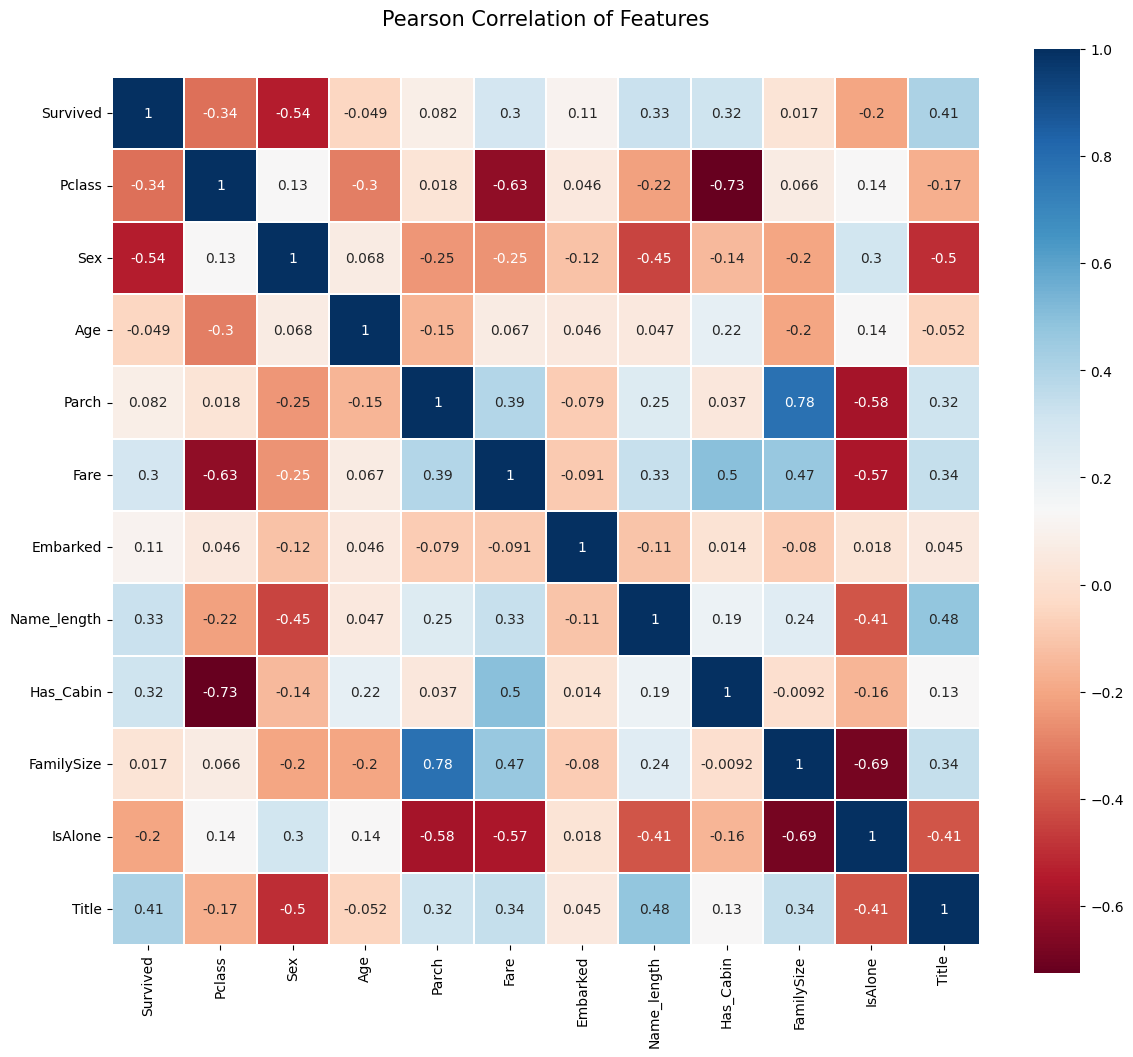

In [39]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(data_initial.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

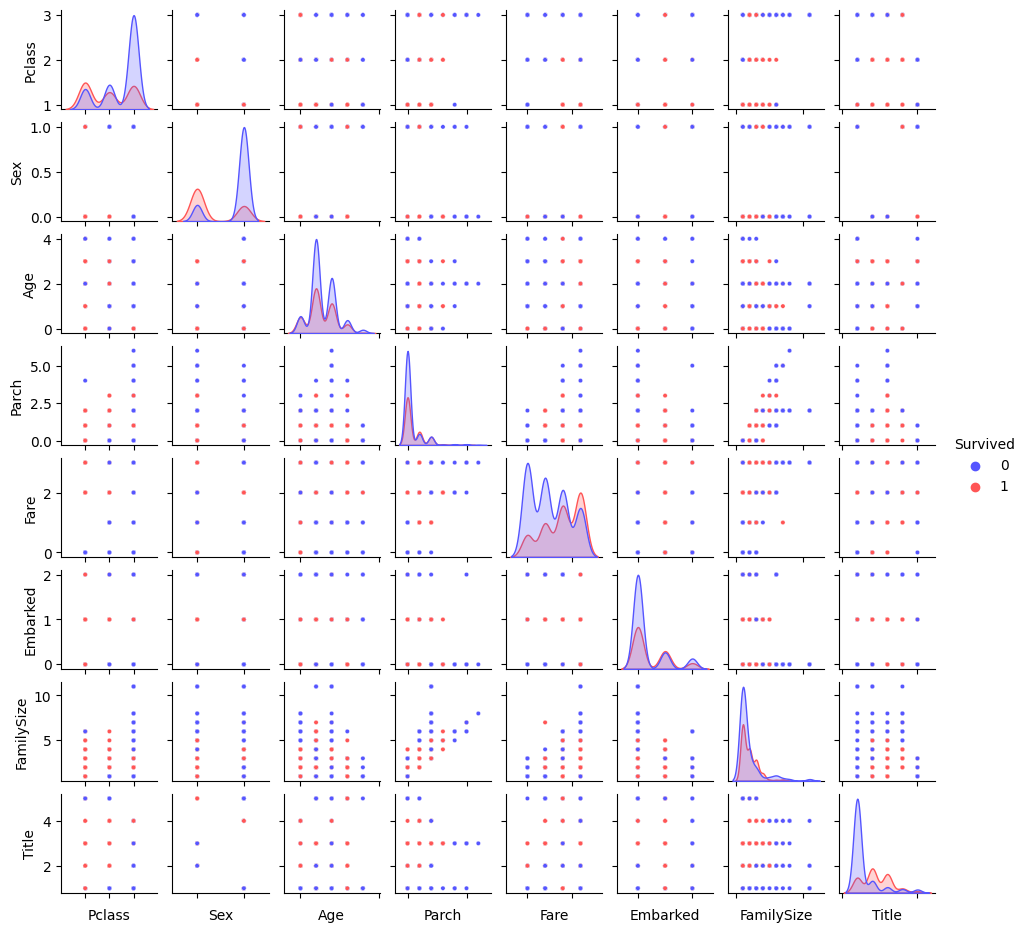

In [40]:
g = sns.pairplot(data_initial[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', 
                        u'Embarked', u'FamilySize', u'Title']], 
                 hue='Survived', palette = 'seismic', size=1.2, plot_kws=dict(s=10))
g.set(xticklabels=[])

# My solution:
  
So, we have 2 datasets with new features.

### Building the model

### 1.

For current classification task the following approach will be considered:
- Stacking algorithm:
- Base algorithms:
    - RandomForestClassifier,
    - SVC,
    - GradientBoostingClassifier,
    - and LogisticRegression;
- Meta Algorithm - XGBoost.

1. Train test data split will be made with random_state=17 and test_size=.3
  
- "Survived" column - is the Target variable
- All other columns - features for the model  

Below, parameters for all of Base algorithms are shown. These parameters will be tuned on 5-Fold cross-validation with use of *GridSearchCV* approach:

In [41]:
data_initial.head(2)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3


In [42]:
data = data_initial.drop(columns=['Survived'])
data.head(2)

,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,3,1,1,0,0,0,23,0,2,0,1
1,1,0,2,0,3,1,51,1,2,0,3


In [43]:
targets = data_initial[['Survived']]
targets.head(2)

,Survived
0,0
1,1


In [44]:
from sklearn.model_selection import (GridSearchCV,
                                     train_test_split,
                                     StratifiedKFold,
                                     cross_val_predict)

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

#base algorithms:
rfc = RandomForestClassifier()
svc = SVC()
gbc = GradientBoostingClassifier()
lr = LogisticRegression()

# base algorithms parameters
rfc_params = {'n_estimators': range(10, 100, 10), # RandomForestClassifier
              'min_samples_leaf': range(1, 5)}

svc_params = {'kernel': ['linear', 'rbf'], # SVC
              'C': np.arange(0.1, 1, 0.2)}

gbc_params = {'learning_rate': np.arange(0.1, 0.6, 0.1)} # GradientBoostingClassifier

lr_params = {'C': np.arange(0.5, 1, 0.1)}

skf = StratifiedKFold(n_splits=5, random_state=17, shuffle=True)

In [45]:
# data splitting:
train, test, train_true, test_true = train_test_split(data, targets, test_size=0.3, random_state=17)
print(f'initial data shape: {data_initial.shape}')
print(f'train shape: {train.shape}')
print(f'answers for train dataset shape: {train_true.shape}')
print(f'test shape {test.shape}')
print(f'test answers shape: {test_true.shape}')

initial data shape: (891, 12)
train shape: (623, 11)
answers for train dataset shape: (623, 1)
test shape (268, 11)
test answers shape: (268, 1)


### 2.
1. Object of GridSearchCV will be determined for all of parameters of base algorithms.  
Parameter cv will be equal *skf*

2. Each of base algorithms will be fitted on train dataset. Best composition of parameters for each algorithm will be shown.

3. Each base algorithm will then produce their prediction on Validation data.

In [46]:
# Grid Search parameters are choosed based on whole training dataset (data, targets):

rfc_grid = GridSearchCV(estimator=rfc,
                        param_grid = rfc_params).fit(data, targets)

svc_grid = GridSearchCV(estimator=svc,
                       param_grid = svc_params).fit(data, targets)

gbc_grid = GridSearchCV(estimator=gbc,
                       param_grid=gbc_params).fit(data, targets)

lr_grid = GridSearchCV(estimator=lr,
                      param_grid=lr_params).fit(data, targets)

In [47]:
df_cv_result = pd.DataFrame(rfc_grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]
df_cv_result[df_cv_result['mean_test_score'] == df_cv_result['mean_test_score'].max()]

,mean_test_score,std_test_score,params
20,0.828291,0.021129,"{'min_samples_leaf': 3, 'n_estimators': 30}"


In [48]:
rfc_grid.best_params_

{'min_samples_leaf': 3, 'n_estimators': 30}

In [49]:
# best models:
print(f'Best model {rfc_grid.best_estimator_}')
print(f'Best model {svc_grid.best_estimator_}')
print(f'Best model {gbc_grid.best_estimator_}')
print(f'Best model {lr_grid.best_estimator_}')

rfc_model = rfc_grid.best_estimator_
svc_model = svc_grid.best_estimator_
gbc_model = gbc_grid.best_estimator_
lr_model = lr_grid.best_estimator_

models = [rfc_model, svc_model, gbc_model, lr_model]

Best model RandomForestClassifier(min_samples_leaf=3, n_estimators=30)
Best model SVC(C=0.1, kernel='linear')
Best model GradientBoostingClassifier(learning_rate=0.2)
Best model LogisticRegression(C=0.5)


In [50]:
# stacking function:

def stacking(models, meta_alg,
             train, train_true, test, test_true=None,
             random_state=None, test_base_size=None, cv=5):
    """
    models - list of models objects,
    meta_alg - object of meta algorithm
    train - train part of initial data (after 1st split)
    train_true - answers for train part of data
    test - test part of initial data (after 1st split)
    test_true - answers for test part of data
    test_base_size - size of test_base part of train data, default-None,
        if None, then cross validation is used for meta-features creation
    cv - number of folds for cross-validation (is used if test_base_size=None)
    """    
    
    if test_base_size is None:
        print('use cross validation for meta-features creation')
        scores_auc = {} # dict for quality metrics (roc_auc_score)
        scores_accuracy = {} # dict for accuracy score
        meta_mtrx_train = np.empty((train.shape[0], len(models)))
        # 1) meta_features by cv:
        for n, model in enumerate(models):
            meta_mtrx_train[:, n] = cross_val_predict(model, train, train_true, cv=cv, method='predict')
        # 2) meta fitting:
        meta_model = meta_alg.fit(meta_mtrx_train, train_true)     
        # 3) meta_mtrx_test:
        meta_mtrx_test = np.empty((test.shape[0], len(models)))
        for n, model in enumerate(models):
            models[n] = models[n].fit(train, train_true) 
            meta_mtrx_test[:, n] = model.predict(test) 
            if test_true is not None:
                base_pred = model.predict(test)
                scores_auc[str(models[n])] = roc_auc_score(test_true, base_pred)
                scores_accuracy[str(models[n])] = accuracy_score(test_true, base_pred)
        # 4) meta_predictions:
        meta_pred = meta_model.predict(meta_mtrx_test)
        if test_true is not None:
            meta_pred = meta_model.predict(meta_mtrx_test)
            scores_auc['meta'] = roc_auc_score(test_true, meta_pred)
            scores_accuracy['meta'] = accuracy_score(test_true, meta_pred)
        # if scores were calculated, then write in df:
        if len(scores_auc) > 0:
            df_scores_auc = pd.DataFrame(scores_auc, index=[0]).transpose().reset_index()
            df_scores_auc.columns = ['algorithm', 'roc_auc_score']
            df_scores_auc['alg'] = df_scores_auc['algorithm'].str[:10]
            
            df_scores_accuracy = pd.DataFrame(scores_accuracy, index=[0]).transpose().reset_index()
            df_scores_accuracy.columns = ['algorithm', 'roc_auc_score']
            df_scores_accuracy['alg'] = df_scores_accuracy['algorithm'].str[:10]
        else:
            df_scores_auc = scores_auc
            df_scores_accuracy = scores_auc
        return meta_model, meta_pred, df_scores_auc, df_scores_accuracy, meta_mtrx_train, meta_mtrx_test
    
    elif test_base_size > 0 and test_base_size < 1:
        print('use Blending Schema')
        meta_pred = 0
        # 1) splitting data:
        train_base, test_base, train_base_true, test_base_true = train_test_split(train, train_true,
                                                                test_size=test_base_size)
        # 2) meta_mtrx_train:
        meta_mtrx_train = np.empty((test_base.shape[0], len(models)))
        scores = {}
        for n, model in enumerate(models):
            # base learner fitting:
            models[n] = models[n].fit(train_base, train_base_true)
            meta_mtrx_train[:, n] = models[n].predict(test_base)
        # 3) meta-alg fitting:
        meta_model = meta_alg.fit(meta_mtrx_train, test_base_true)
        # 4) meta_mtrx_test:
        meta_mtrx_test = np.empty((test.shape[0], len(models)))
        for n, model in enumerate(models):
            meta_mtrx_test[:, n] = model.predict(test)
            # comparison base_predict with 
            base_pred = model.predict(test)
            if test_true is not None:
                scores_auc[str(models[n])] = roc_auc_score(test_true, base_pred)
                scores_accuracy[str(models[n])] = accuracy_score(test_true, base_pred)
        if test_true is not None:
            meta_pred = meta_model.predict(meta_mtrx_test)
            scores_auc['meta'] = roc_auc_score(test_true, meta_pred)
            scores_accuracy['meta'] = accuracy_score(test_true, meta_pred)
        # if scores were calculated, then write in df:
        if len(scores_auc) > 0:
            df_scores_auc = pd.DataFrame(scores_auc, index=[0]).transpose().reset_index()
            df_scores_auc.columns = ['algorithm', 'roc_auc_score']
            df_scores_auc['alg'] = df_scores_auc['algorithm'].str[:10]
            
            df_scores_accuracy = pd.DataFrame(scores_accuracy, index=[0]).transpose().reset_index()
            df_scores_accuracy.columns = ['algorithm', 'roc_auc_score']
            df_scores_accuracy['alg'] = df_scores_accuracy['algorithm'].str[:10]
        else:
            df_scores_auc = scores_auc
            df_scores_accuracy = scores_auc
    else:
        raise ValueError("test_size must be between 0 and 1")
    
    return meta_model, meta_pred, df_scores_auc, df_scores_accuracy, meta_mtrx_train, meta_mtrx_test

### 3.
with use of GridSearchCV and stated parameters Meta-Algorithm will be tuned on Meta-features. Matrix of meta-features will be produced based on prediction of base algorithms on validation data. Best parameters for Meta-Algorithm (XGBoosting) will be shown:

In [51]:
# meta algorithm:
meta = XGBClassifier(random_state=17)

In [52]:
xgb_params = {'n_estimators': range(10, 100, 5),
              'eta': np.arange(0.1, 1., .1),
              'min_child_weight': range(1, 10, 1),
              'subsample': np.arange(0.1, 1., 0.2)}

In [53]:
# use algorithm to get meta_mtrx_test, meta_mtrx_train
meta_model, meta_pred, df_scores_auc, df_scores_accuracy, meta_mtrx_train, meta_mtrx_test = \
    stacking(models=models, meta_alg = meta, train=train, train_true=train_true,
            test = test, test_true=test_true, test_base_size=None, cv=5)
print('done')

use cross validation for meta-features creation
done


In [ ]:
# takes long time to complete!
t = datetime.now()
meta_grid = GridSearchCV(meta, xgb_params, cv=5).fit(meta_mtrx_train, train_true)
print(f'execution time: {datetime.now() - t}')

In [ ]:
print(f'Best params for meta algorithm: {meta_grid.best_params_}')

In [ ]:
meta_model = meta_grid.best_estimator_

In [ ]:
meta_model

In [57]:
# to skip long grid search:----------

# parameters of best meta_model not to use big function again:
eta_best = 0.1
min_child_weight_best = 9
n_estimators_best = 50
subsample_best = 0.3

In [58]:
meta_model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.1, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=9, monotone_constraints='()',
              n_estimators=50, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.30000000000000004, tree_method='exact',
              validate_parameters=1, verbosity=None)

### 4.
На основе алгоритма из предыдущего домашнего задания постройте стекинг (используйте 5-кратную кросс-валидацию) для всех моделей с наилучшими подобранными параметрами. В качестве тренировочных данных используйте весь датасет train.csv, а в качестве тестовых - весь датасет test.csv. Сделайте прогноз мета-алгоритма для test.csv.

In [59]:
meta_model, meta_pred, df_scores_auc, df_scores_accuracy, meta_mtrx_train, meta_mtrx_test = \
    stacking(models=models, meta_alg = meta_model, train=data, train_true=targets,
            test = test_final, test_true=None, test_base_size=None, cv=5)

use cross validation for meta-features creation


In [60]:
meta_pred[:5]

array([0, 1, 0, 0, 1])

### 5. Predictions:

In [61]:
def write_to_submission_file(predictions, PassengerID, out_file='Submission.csv', columns=['PassengerID', 'Survived']):
    meta_pred_df = pd.DataFrame(meta_pred, columns=['Survived'])
    predicted_df = pd.merge(test_final_passenger_id, meta_pred_df, left_index=True, right_index=True, how='outer')
    predicted_df.to_csv(out_file, index=False)
    return predicted_df

In [62]:
predicted_df = write_to_submission_file(meta_pred, PassengerID=test_final_passenger_id)

In [63]:
predicted_df.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


### 6.
Result from Competition system check:
Accuracy = 0.76555  

this score is not really close to the best possible on this competition (100 %), however this approach can be further developed to increase the efficiency

In [66]:
# score on test part:
meta_model_test, meta_pred_test, df_scores_auc_test, df_scores_accuracy_test, meta_mtrx_train_test, meta_mtrx_test_test = \
    stacking(models=models, meta_alg = meta_model, train=train, train_true=train_true,
            test = test, test_true=test_true, test_base_size=None, cv=5)

use cross validation for meta-features creation


Now let us see what result  was achieved by each model:

In [67]:
df_scores_auc_test

,algorithm,roc_auc_score,alg
0,"RandomForestClassifier(min_samples_leaf=3, n_e...",0.767774,RandomFore
1,"SVC(C=0.1, kernel='linear')",0.777558,"SVC(C=0.1,"
2,GradientBoostingClassifier(learning_rate=0.2),0.761405,GradientBo
3,LogisticRegression(C=0.5),0.785792,LogisticRe
4,meta,0.784472,meta


In [68]:
df_scores_accuracy_test

,algorithm,roc_auc_score,alg
0,"RandomForestClassifier(min_samples_leaf=3, n_e...",0.783582,RandomFore
1,"SVC(C=0.1, kernel='linear')",0.787313,"SVC(C=0.1,"
2,GradientBoostingClassifier(learning_rate=0.2),0.776119,GradientBo
3,LogisticRegression(C=0.5),0.798507,LogisticRe
4,meta,0.798507,meta


We can see that metric was not improved by the use of Stacking (Logistic regression showed the best score for both considered metrics and Meta Algorithm could not improve it)

This is one of the main vector for further improvement of the model